In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import os
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [3]:
# set environment as googledrive to folder "resource"
data_path =  "/IdeologyDetect/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/IdeologyDetect/dataset/quotes/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir(data_path)

['quotes_train_file.gsheet',
 'quotes_train_file_v1.csv',
 'quotes_train_file_v2.gsheet',
 'train_file_v2.csv']

In [5]:
df=pd.read_csv(data_path+"/train_file_v2.csv", delimiter=",")
df=df.dropna()
df.ideology=df.ideology.astype(int)
df.ideology.value_counts()

4    13097
1     1698
3     1006
0      805
2      363
Name: ideology, dtype: int64

In [6]:
df.head()

,ideology,sentence
0,0,abdde sağ çok geniştir neo conlardan neredeyse...
1,0,abd devrimi sırasında veya yakın zamanda oaxac...
2,0,abdnin illuminati olarak bilinen grubun nihai ...
3,0,açıkçası ben bir anarşist değilim felsefi olar...
4,0,adaletsiz bir toplumda adil bir insanın tek ye...


In [7]:
anarsizmAug=df[df.ideology==0].sample(805)
komunAug=df[df.ideology==1].sample(1000)
liberalizmAug=df[df.ideology==2].sample(363)
millliyetcilikAug=df[df.ideology==3].sample(1000)
muhafazakarAug=df[df.ideology==4].sample(1000)
df=pd.concat([anarsizmAug, komunAug,liberalizmAug, millliyetcilikAug, muhafazakarAug], axis=0)

In [8]:
df.head()

,ideology,sentence
653,0,popüler anarşizm anlayışı şiddetli devlet karş...
405,0,genel olarak işçi hareketlerinde şiddetsiz baş...
719,0,şüphesiz anarşist fikirler iktidardakiler için...
280,0,bu bilgi yönetim ticaret mülkiyet kişisel ve ç...
671,0,savaş devletin sağlığıdır bu karşı konulamaz g...


In [9]:
"""df2= pd.read_csv(data_path+"N11_Kaba.csv")
df2['SENTIMENT']="Kaba"
df2=df2.drop("ANSWER",axis=1)
df2=df2.drop("Unnamed: 2",axis=1)
df2.rename(columns={'CONTENT':'Mağaza'}, inplace=True)
df = pd.read_csv(data_path + 'n11_Sentiment - n11_Sent2.csv')
df3=pd.read_csv(data_path+"pseudolabel.csv")
df3=df3.drop("Unnamed: 0",axis=1)
df=df.dropna(subset=["SENTIMENT"])
df=df.drop("Unnamed: 2",axis=1)
df=df.reset_index(drop=True)
df=pd.concat([df,df2],axis=0,ignore_index=True)
df=df.dropna()
notrAug=df3[df3.SENTIMENT==1].sample(1440)
saygAug=df3[df3.SENTIMENT==2].sample(423)
df['SENTIMENT'] = LabelEncoder().fit_transform(df['SENTIMENT'])
df=pd.concat([df,notrAug,saygAug],axis=0)"""

'df2= pd.read_csv(data_path+"N11_Kaba.csv")\ndf2[\'SENTIMENT\']="Kaba"\ndf2=df2.drop("ANSWER",axis=1)\ndf2=df2.drop("Unnamed: 2",axis=1)\ndf2.rename(columns={\'CONTENT\':\'Mağaza\'}, inplace=True)\ndf = pd.read_csv(data_path + \'n11_Sentiment - n11_Sent2.csv\')\ndf3=pd.read_csv(data_path+"pseudolabel.csv")\ndf3=df3.drop("Unnamed: 0",axis=1)\ndf=df.dropna(subset=["SENTIMENT"])\ndf=df.drop("Unnamed: 2",axis=1)\ndf=df.reset_index(drop=True)\ndf=pd.concat([df,df2],axis=0,ignore_index=True)\ndf=df.dropna()\nnotrAug=df3[df3.SENTIMENT==1].sample(1440)\nsaygAug=df3[df3.SENTIMENT==2].sample(423)\ndf[\'SENTIMENT\'] = LabelEncoder().fit_transform(df[\'SENTIMENT\'])\ndf=pd.concat([df,notrAug,saygAug],axis=0)'

In [10]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = df.sentence.values
max_len = 512

In [11]:
training = df.groupby('ideology').apply(lambda x : x.sample(frac = 0.80))
test = pd.concat([df,training]).drop_duplicates(keep=False)


print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.sentence.values
training_labels = training.ideology.values

Training:  3334
Test:  834


In [12]:
"""test=pd.read_csv(data_path + 'n11_Sentiment - n11_Sent.csv')
test=test.drop("Unnamed: 2",axis=1)
test=test[pd.isna(test.SENTIMENT)]"""

'test=pd.read_csv(data_path + \'n11_Sentiment - n11_Sent.csv\')\ntest=test.drop("Unnamed: 2",axis=1)\ntest=test[pd.isna(test.SENTIMENT)]'

In [13]:
import logging
logging.basicConfig(level=logging.ERROR)

In [14]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        truncation=True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  her devlet güçlülerin ayrıcalıklarını korur
Token IDs: tensor([     2,   2110,   2780,  94211,   2174, 122059,  15760,      3,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0

In [15]:
"""max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)"""

"max_len = 0\n\n# For every sentence...\nfor sent in sentences:\n\n    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.\n    input_ids = tokenizer.encode(sent, add_special_tokens=True)\n\n    # Update the maximum sentence length.\n    max_len = max(max_len, len(input_ids))\n\nprint('Max sentence length: ', max_len)"

In [16]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 8

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            test, # The validation samples.
            sampler = SequentialSampler(test), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

number_of_categories = len(df['ideology'].unique())

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [17]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [18]:
torch.cuda.empty_cache()

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 10

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of    417.    Elapsed: 0:00:14.
Batch    20  of    417.    Elapsed: 0:00:29.
Batch    30  of    417.    Elapsed: 0:00:43.
Batch    40  of    417.    Elapsed: 0:00:58.
Batch    50  of    417.    Elapsed: 0:01:12.
Batch    60  of    417.    Elapsed: 0:01:27.
Batch    70  of    417.    Elapsed: 0:01:41.
Batch    80  of    417.    Elapsed: 0:01:56.
Batch    90  of    417.    Elapsed: 0:02:10.
Batch   100  of    417.    Elapsed: 0:02:25.
Batch   110  of    417.    Elapsed: 0:02:39.
Batch   120  of    417.    Elapsed: 0:02:54.
Batch   130  of    417.    Elapsed: 0:03:08.
Batch   140  of    417.    Elapsed: 0:03:23.
Batch   150  of    417.    Elapsed: 0:03:37.
Batch   160  of    417.    Elapsed: 0:03:51.
Batch   170  of    417.    Elapsed: 0:04:06.
Batch   180  of    417.    Elapsed: 0:04:20.
Batch   190  of    417.    Elapsed: 0:04:35.
Batch   200  of    417.    Elapsed: 0:04:49.
Batch   210  of    417.    Elapsed: 0:05:04.
Batch   220  of    417.  

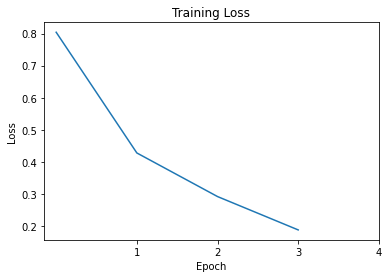

In [26]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [27]:
test_texts = test.sentence.values
test_labels = test.ideology.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        truncation = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 2  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []
from torch import nn
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)


  logits = outputs[0]
  toxics = nn.functional.softmax(logits, dim=1)
  toxics = toxics.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()    

  predictions.append(toxics)
  true_labels.append(label_ids)

print('Prediction completed')
preds_probable=[]
prediction_set = []

for i in range(len(true_labels)):
  preds_probable.append(predictions[i])
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [29]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'Anarşizm',
                          '1':'Komunizm',
                          '2':'Liberalizm',
                          '3':'Milliyetçilik',
                          '4':'Muhafazakarlık'})

print(report)

F-Score:  0.7589585879766318
Recall:  0.7499977877988598
Precision:  0.7758218489023578
             Anarşizm    Komunizm  ...   macro avg  weighted avg
precision    0.765517    0.685714  ...    0.775822      0.787286
recall       0.689441    0.720000  ...    0.749998      0.787770
f1-score     0.725490    0.702439  ...    0.758959      0.784969
support    161.000000  200.000000  ...  834.000000    834.000000

[4 rows x 8 columns]


In [30]:
report

,Anarşizm,Komunizm,Liberalizm,Milliyetçilik,Muhafazakarlık,accuracy,macro avg,weighted avg
precision,0.765517,0.685714,0.703704,0.785088,0.939086,0.78777,0.775822,0.787286
recall,0.689441,0.720000,0.520548,0.895000,0.925000,0.78777,0.749998,0.787770
f1-score,0.725490,0.702439,0.598425,0.836449,0.931990,0.78777,0.758959,0.784969
support,161.000000,200.000000,73.000000,200.000000,200.000000,0.78777,834.000000,834.000000


In [33]:
from time import gmtime, strftime
date = strftime("%d_%m_%Y_%H_%M_%S", time.gmtime(time.mktime(time.strptime("23_09_2020_15_36_00", "%d_%m_%Y_%H_%M_%S"))))
date = str(date)
print(date)

23_09_2020_15_36_00


In [34]:
torch.save(model.state_dict(), "/content/drive/My Drive/IdeologyDetect/model/" + date +  "___model_ideology.pt")

In [35]:
test['Predictions'] = prediction_scores

In [36]:
WrongPredictions=test[test['ideology']!=test['Predictions']]


In [37]:
WrongPredictions.shape

(177, 3)

In [38]:
pd.options.display.max_colwidth = 4000
pd.options.display.max_rows = 4000
WrongPredictions

,ideology,sentence,Predictions
405,0,genel olarak işçi hareketlerinde şiddetsiz başarıya ulaşılabilen durumlar dışında şiddet yoluyla başarı beklenemez,1
655,0,proletaryayı pohpohlayan onları mazur gören öven çelenklerle süsleyenlerin çokluğuyla birleşmek istemiyorum hayır ah seçkin rüzgar torbaları şevkiniz hiçbir şeyi gizlemiyor insanlar her zaman oradadır aptalca korkakça boyun eğmiştir ve kendimi üstün gören ben de öyle olmayı arzuluyorum ve hem burjuvazi hem de proletarya üstünlüğümü ödeyecek,1
505,0,işi ortadan kaldırmak ona nicel ve nitel olmak üzere iki yönden gitmeyi gerektirir bir yandan nicel açıdan yapılan iş miktarını büyük ölçüde azaltmamız gerekiyor şu anda işlerin çoğu faydasız ya da daha kötü ve biz ondan kurtulmalıyız öte yandan ve bence meselenin özü bu ve devrimci yeni ayrılış geriye kalan yararlı işi alıp onu diğer zevkli oyunlardan ayırt edilemeyen hoş bir oyun ve zanaat benzeri oyun çeşitliliğine dönüştürmeliyiz bunun dışında yararlı son ürünler ortaya çıkarır elbette bu onları daha az cazip yapmamalıdır o zaman güç ve mülkiyetin tüm yapay engelleri yıkılabilir yaratılış rekreasyon haline gelebilir ve hepimiz birbirimizden korkmayı bırakabiliriz,1
635,0,paul avrich kronstadtın trajedisinin isyancılara sempati duymakla birlikte komünistlerin onları bastırmasını haklı çıkarmak olduğunu öne sürüyor bence gerçek trajedi pek çok insanın uzun zamandır tam da bunu yapmış olması kronstadttan berline budapeşte ve praga tiranlığın bir şekilde ilerici olduğu gerekçesiyle haklı gösterildi kıtlık ve azgelişmişlik durumlarında iktidara yükselmelerinin kaçınılmaz olduğu argümanı kabul edilse bile tiranları kutsal saymaya gerek yoktur,1
601,0,niteliksel bir dönüşüm yeni bir yaşayan hayat veren vahiy yeni bir cennet ve yeni bir dünya içinde mevcut tüm uyumsuzluklarımızın uyumlu bir bütün halinde çözüleceği genç ve güçlü bir dünya olacak,1
349,0,devrimin sosyal bir savaş olduğunu gerçekçi bir şekilde kabul etmeliyiz çünkü savaşı sevdiğimiz için değil statükonun düşük yoğunluklu bir savaş olduğunu ve devlete meydan okumanın bu savaşın yoğunlaşmasıyla sonuçlandığını kabul ettiğimiz için ayrıca devrimin kişiler arası çatışmayı gerektirdiğini de kabul etmeliyiz çünkü yok etmemiz gereken merkezileştirici kurumları savunmak için belirli insan sınıfları istihdam edilmektedir kanun ve düzenin temsilcileri olarak kendilerini insanlıktan çıkarmaya devam eden insanlar ihtiyaçlarının özerk olarak gerçekleşmesini artık engelleyemeyene kadar gerekli olan her yolla mağlup edilmelidir,1
658,0,resmi olarak onaylanmış bilginin yaratılması bilginin sahipliğini kadınlardan ve yerli toplumlardan kaldırdı ve hepsini katı kapitalist kontrol altına aldı yüzyıllardır kullanılan ve test edilen uygulamalar büyük adamlar bunları onaylayıp sahipliğini talep edene kadar resmi kabul edilmedi veya test edilmedi,1
476,0,ingilterenin işçileri endüstrileri atalarının yönettiği gibi yönetemedikleri için loncaların zamanındakinden daha mı az zeki bize yönetemeyeceğinizi onları organize edemeyeceğinizi söyleyin efendileriniz kadar onları da yönetemezseniz çok yanılmış olmalıyım kapitalistler endüstrileri üretken olacak kadar iyi yönetemediklerinden sürekli olarak şikayet ediyorlar size geçim ücreti ödeyemeyecek kadar fakirler peki bizi sömürmeden sektörü yönetemezlerse bırakın gitsinler onları istemiyoruz henüz yaptıklarından daha iyi idare edebiliriz,1
555,0,komplo teorileri gerekçe olarak soykırım veya dünya egemenliği ile gereksiz yere kötü olan komploculara dayanma eğilimindedir,3
564,0,kuruluş askeri sanayi kompleksidir mıc onları bilirsiniz bunlar sizin bankalarınız seçtiğiniz hükümet büyük şirketler uşak medya ve organize suçlar onları tanıyorsunuz belki onlara güveniyorsunuz son on yılda ya da birkaç yılda onlar hakkında biraz ya da biraz daha fazla huzursuz hissetmeye başlamış olabilirsiniz,1


In [ ]:
#df.to_csv("/content/drive/My Drive/resources/allData.csv",index=False)